# Pages report

This notebook is a workaround to build indivual page reports. It defines the main functions to display a report (`display_report(pagename)`). That allow other notebooks to import and explore the various data about the computed data from wikipedia pages and subsequent relationshipts (networks of users-pages, pages-pages and users-users). It also include synthesis of time wise analysis like page views analytics.

This page is mainly used by the [page explorer](page explorer.ipynb) notebook.

In [1]:
%run "libraries.ipynb"

import networkx as nx
from IPython.display import display, HTML

# importing datasets

In [2]:
# list of page names
pages = codecs.open("data/pagenames.txt","r", "utf-8-sig").readlines()
pages = map(lambda x: x.strip(), pages)

# page graph obtained by projecting page-editor bi-partite graph
pages_graph = nx.read_gexf("data/pages-linked-by-coeditors.gexf")

# page graph obtained by projecting page-editor bi-partite graph
pages_editors_graph = nx.read_gexf("data/pages-editors.gexf")

In [3]:
def table_to_html(data, cols=[]):
    html = "<table>"
    html += "<tr>"
    for column_content in cols:
        html += "<th>%s</th>" % (column_content)
    html += "</tr>"
    
    for d in data:
        html += "<tr>"
        for column_content in d:
            html += "<td>%s</td>" % (column_content)
        html += "</tr>"
    html += "</table>"
        
    return HTML(html) 

def display_report(page):
    display(HTML("<h2>%s</h2>" % (page)))
    
    #display(HTML("<div style=\"float:left\">"))    
    display(HTML("<h3>co-edited pages</h3>"))

    nb = sorted(pages_graph["p:%s" % (page)].items(),
            key=lambda (k,x): -int(x["coeditors"]))

    data = []

    # calculate rank in neighbor top co-edited ranking
    for name, info in nb:
        nb_mirror = sorted(pages_graph[name].items(),
                key=lambda (k,x): -int(x["coeditors"]))
        nb_mirror = [ x[0] for x in nb_mirror ]
        
        editors = pages_editors_graph[name]        
        info["editors"] = len(editors)
        info["exclusive editors"] = len([n for n in editors if len(pages_editors_graph[n]) == 1 ])

        info["ranking"] = nb_mirror.index("p:%s" % (page)) + 1

    #print nb

    for name, info in nb[0:10]:
        data.append([ u"<a href=\"http://en.wikipedia.org/wiki/{0}\" target=\"_blank\">{0}</a>".format(name.split(":")[1]),
                     info["editors"],
                     info["coeditors"],
                     float(info["coeditors"]) / float(info["editors"]),
                     info["exclusive editors"],
                     info["ranking"]])

    display(table_to_html(data, ["page name", "editors", "co-editors", "co-editors/editors", "exclusive editors" ,"ranking"]))
    #display(HTML("</div>"))    

    #display(HTML("<div style=\"float:left\">"))    
    display(HTML("<h3>ranked first in</h3>"))

    nb_list = [ x[0] for x in nb ]
    data = []

    nb2 = sorted(nb, key=lambda (x): x[1]["ranking"])
    for name, info in nb2[0:10]:
        editors = pages_editors_graph[name]        
        info["editors"] = len(editors)
        info["exclusive editors"] = len([n for n in editors if len(pages_editors_graph[n]) == 1 ])

        data.append([ u"<a href=\"http://en.wikipedia.org/wiki/{0}\" target=\"_blank\">{0}</a>".format(name.split(":")[1]),
                     info["editors"],
                     info["coeditors"],
                     float(info["coeditors"]) / float(info["editors"]),
                     info["exclusive editors"],
                     info["ranking"]])  

    display(table_to_html(data, ["page name", "editors", "co-editors", "co-editors/editors", "exclusive editors" ,"ranking"]))
#     display(HTML("</div>"))    
#     display(HTML("<div style=\"clear:both\"></div>"))
    
    display(HTML("<h3>pageviews and revisions</h3>"))

    pageviews = pd.DataFrame.from_csv("data/pageviews/%s.weekly.csv" % (page))
    pageviews.plot(figsize=(16,4), linewidth="0.5", ylim=0, colormap="Spectral", rot=0)
    plt.plot()
    
    display(HTML("<h3>top editors</h3>"))
    
    revisions = json.load(codecs.open("data/revisions/%s.json" % (page), "r", "utf-8-sig"))
    revisions = pd.DataFrame(revisions)

    top_editors = revisions.groupby("user").groups
    top_editors = sorted(top_editors.items(), key=lambda x: -len(x[1]))
    # top_editors = top_editors.rename(columns = { 1 :'edits'})

    data = []

    for name, edits in top_editors[0:10]:
        data.append(["<a href=\"http://en.wikipedia.org/wiki/User:{0}\" target=\"_blank\">{0}</a>".format(name),
                     len(edits)])

    display(table_to_html(data, ["editor name", "edits"]))

page name,editors,co-editors,co-editors/editors,exclusive editors,ranking
Pi,1799,47,0.0261256253474,886,56
Mathematics,1509,33,0.0218687872763,676,86
Sphere,444,30,0.0675675675676,132,66
Ellipse,490,29,0.0591836734694,147,80
Topology,420,28,0.0666666666667,118,80
Symmetry,390,28,0.0717948717949,107,83
Pythagorean theorem,947,28,0.0295670538543,330,122
Möbius transformation,144,26,0.180555555556,27,25
Circle,807,25,0.0309789343247,253,120
Tetrahedron,322,25,0.0776397515528,75,87


page name,editors,co-editors,co-editors/editors,exclusive editors,ranking
Burmester's theory,16,4,0.25,5,12
Honeycomb (geometry),47,12,0.255319148936,4,14
Roman surface,40,12,0.3,6,17
Point groups in three dimensions,57,16,0.280701754386,7,18
Regular Polytopes (book),16,7,0.4375,0,19
Oval (projective plane),26,9,0.346153846154,3,20
Toric variety,25,7,0.28,4,21
N-sphere,154,25,0.162337662338,41,24
Leech lattice,50,13,0.26,10,24
Point group,51,10,0.196078431373,9,24


editor name,edits
Fropuff,22
Cloudswrest,17
Zundark,15
Tomruen,12
AxelBoldt,10
Sam nead,8
AugPi,4
Charles Matthews,4
87.74.42.114,4
Rgdboer,4


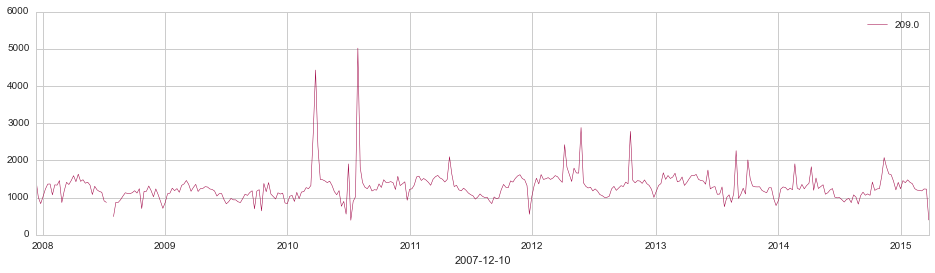

In [4]:
if __name__ == "__main__":
    display_report("3-sphere")